**Preprocessing Image**


In [5]:
import os

dir = '/content/drive/MyDrive/datasets'

for stuff in os.listdir(dir):
  print(stuff)

1
2
4
3


In [12]:
count = 0
for stuff in os.listdir(dir):
  newpath = os.path.join(dir, stuff)
  for images in os.listdir(newpath):
    count += 1
  print(count)

35
83
136
168


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.image import resize

In [8]:
newdir = os.path.join(dir, '1')

(224, 224)


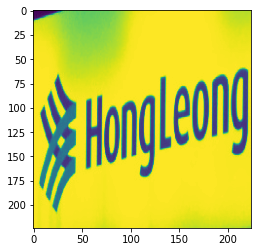

In [9]:
for img in os.listdir(newdir):
  np = os.path.join(newdir,img)
  image = cv2.imread(np, 0)
  print(image.shape)
  plt.imshow(image)
  plt.show()
  break

In [10]:
from tqdm import tqdm
d0 = []
d1 = []
d2 = []
d3 = []

path = [p for p in os.listdir(dir)]
path.sort()

p0 = os.path.join(dir,path[0])
p1 = os.path.join(dir,path[1])
p2 = os.path.join(dir,path[2])
p3 = os.path.join(dir,path[3])
print(f"{p0,p1,p2,p3}")

for img in tqdm(os.listdir(p0)):
  ndir = os.path.join(p0,img)
  image = cv2.imread(ndir,0)
  d0.append(image)
  
for img in tqdm(os.listdir(p1)):
  ndir = os.path.join(p1,img)
  image = cv2.imread(ndir,0)
  d1.append(image)

for img in tqdm(os.listdir(p2)):
  ndir = os.path.join(p2,img)
  image = cv2.imread(ndir,0)
  d2.append(image)

for img in tqdm(os.listdir(p3)):
  ndir = os.path.join(p3,img)
  image = cv2.imread(ndir,0)
  d3.append(image)

  0%|          | 0/48 [00:00<?, ?it/s]

('/content/drive/MyDrive/datasets/1', '/content/drive/MyDrive/datasets/2', '/content/drive/MyDrive/datasets/3', '/content/drive/MyDrive/datasets/4')


100%|██████████| 53/53 [00:00<00:00, 236.82it/s]


In [11]:
del np
import numpy as np
train_data = np.concatenate((np.asarray(d0),np.asarray(d1),np.asarray(d2),np.asarray(d3)),axis=0)

In [13]:
train_data = train_data.reshape(168,224*224)

In [14]:
import joblib
joblib.dump(train_data, os.path.join(dir,'traindata.h5'))

['/content/drive/MyDrive/datasets/traindata.h5']

**Splitting Data**

In [2]:
import joblib
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

dir = 'D:/MMU/TPR/project/gui'

train_data = joblib.load(os.path.join(dir, 'traindata.h5'))

In [4]:
label = np.concatenate((np.ones(35), np.full(48,2), np.full(32,3), np.full(53,4)),axis=0).reshape(168,1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.4, random_state=123)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100, 50176)
(100, 1)
(68, 50176)
(68, 1)


In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
pca = PCA(50, svd_solver='randomized', whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

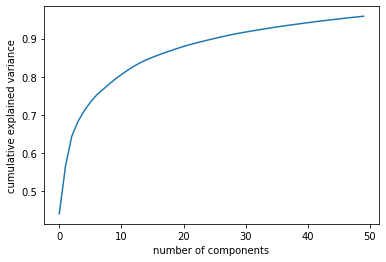

In [22]:
# To guess how much principal components needed, so this i put around 50 seems nice idk
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

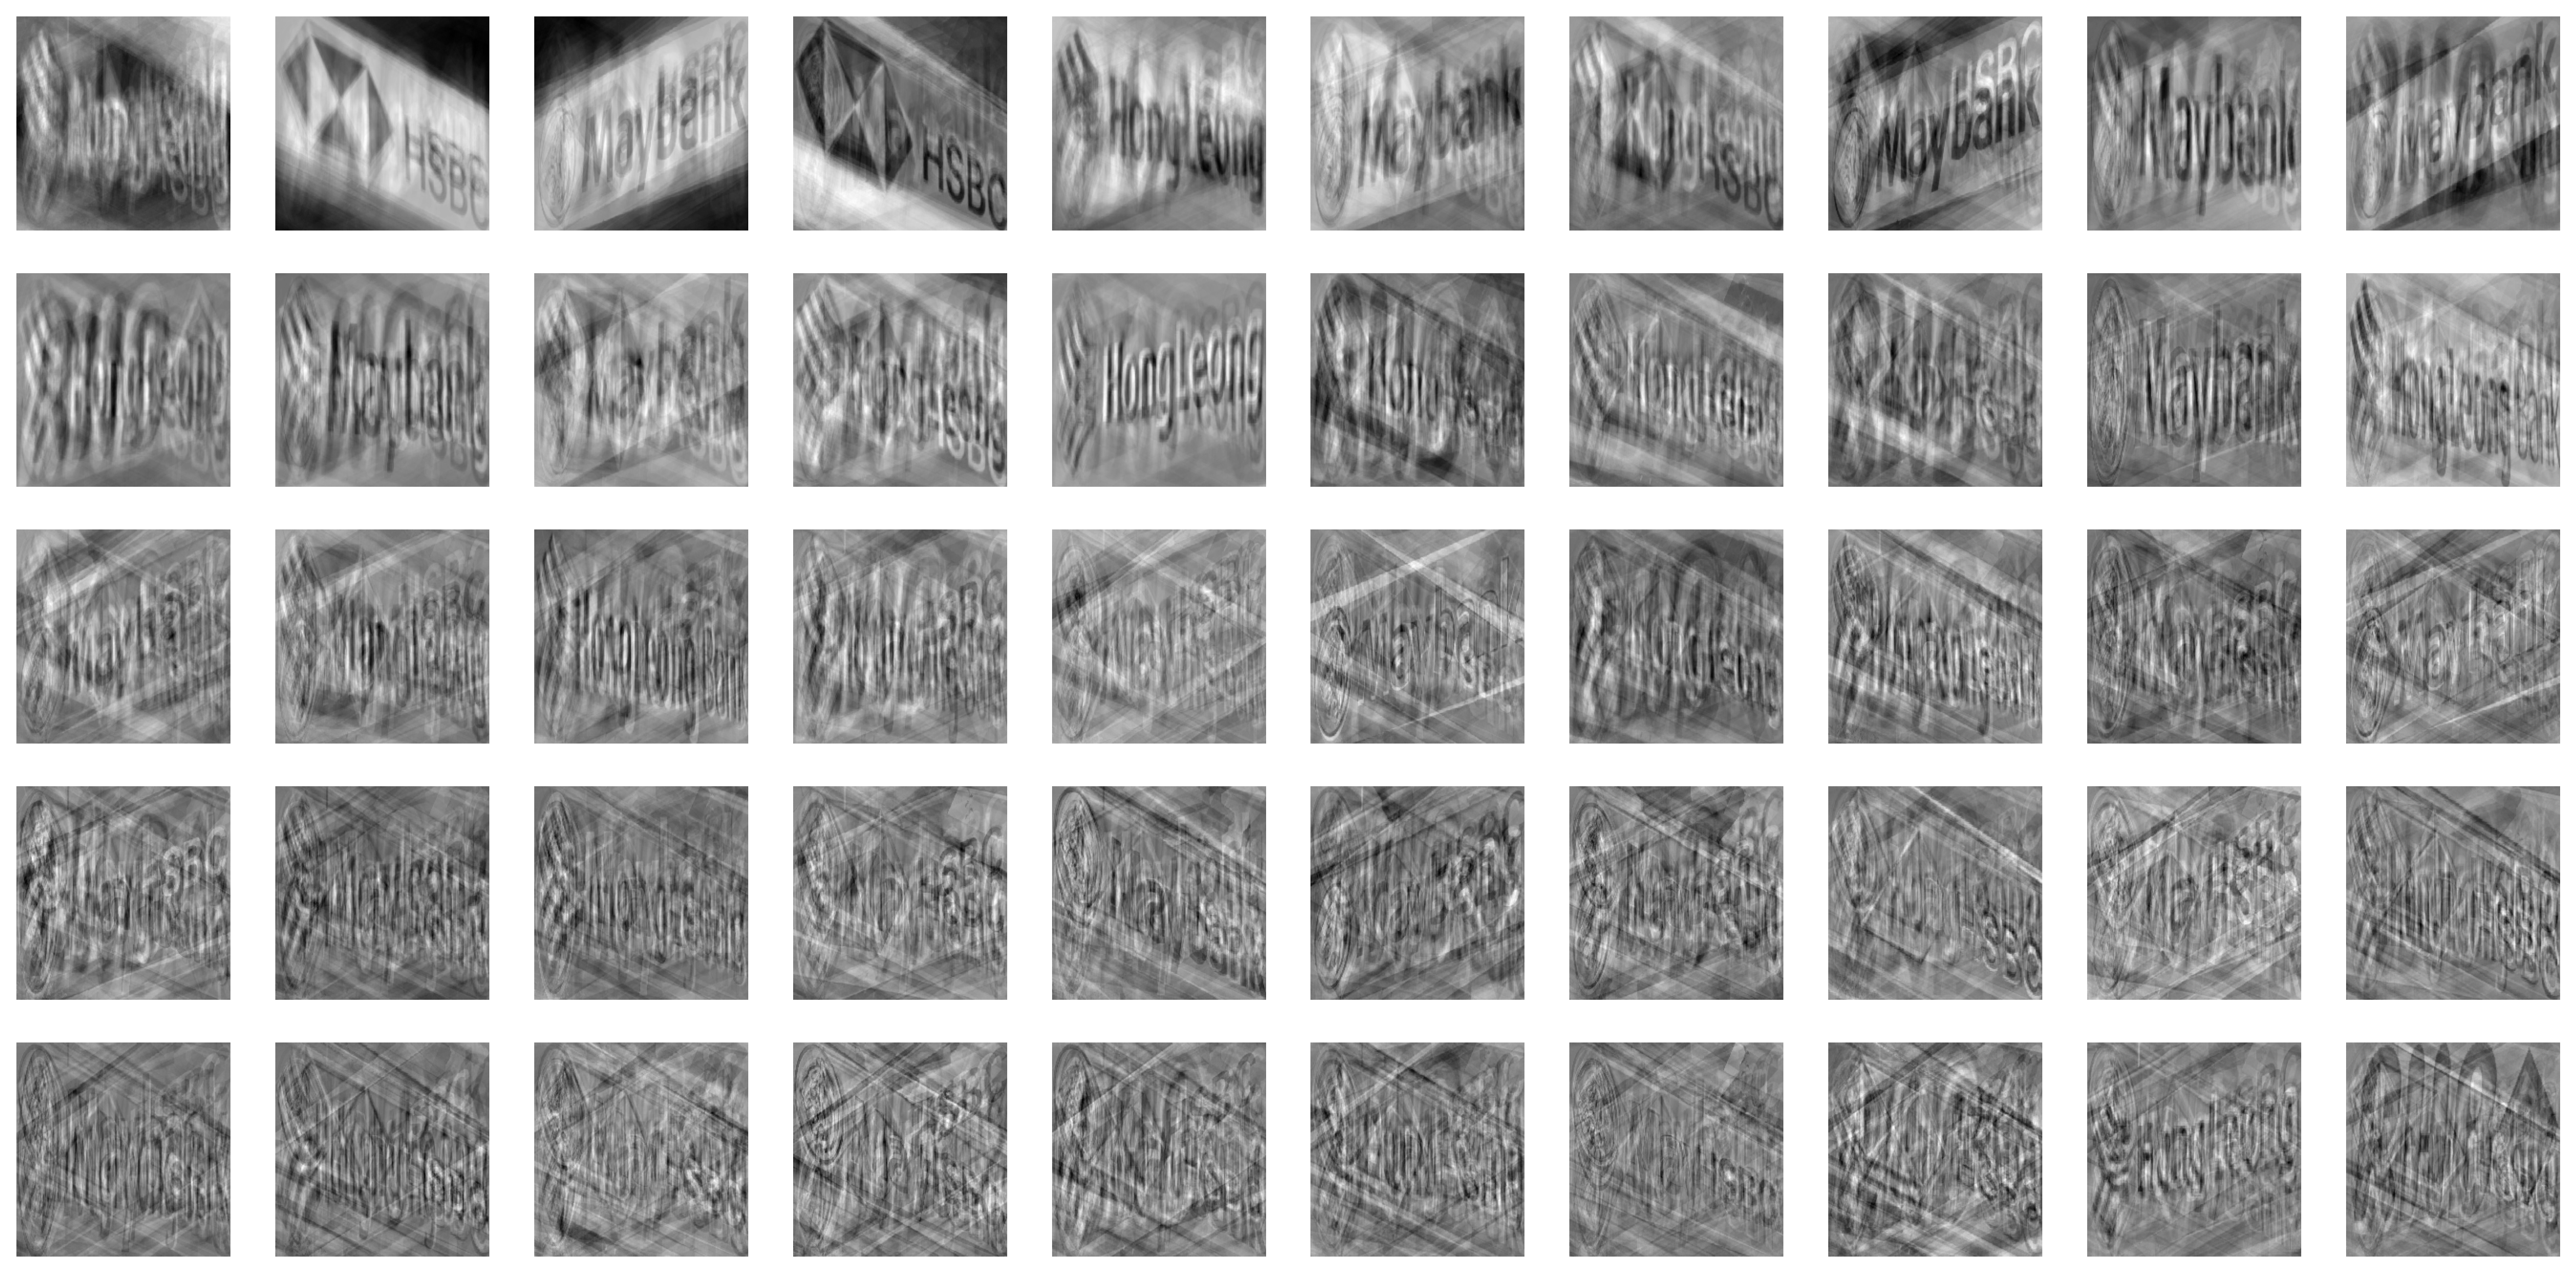

In [21]:
import math
def image_grid(D,H,W,cols=10,scale=1):

    n = np.shape(D)[0]
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
        plt.axis('off')

eigen = pca.components_
image_grid(eigen[:,:], 224,224)
plt.show()

**SVM Implementation**

In [9]:
from sklearn import svm

In [10]:
clf = svm.SVC(gamma=0.001, C=0.1, decision_function_shape='ovr', kernel='linear', verbose=True)
clf.fit(X_train_pca, y_train)

[LibSVM]

SVC(C=0.1, gamma=0.001, kernel='linear', verbose=True)

In [11]:
prediction = clf.predict(X_test_pca)

In [48]:
from sklearn.metrics import classification_report, accuracy_score
acc = accuracy_score(y_test,prediction)

def get_class():
    return classification_report(y_test,prediction)

In [49]:
print(get_class())

              precision    recall  f1-score   support

         1.0       1.00      0.93      0.97        15
         2.0       0.86      1.00      0.92        18
         3.0       1.00      0.82      0.90        11
         4.0       1.00      1.00      1.00        24

    accuracy                           0.96        68
   macro avg       0.96      0.94      0.95        68
weighted avg       0.96      0.96      0.96        68



In [42]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_test, prediction)
cmat

array([[14,  1,  0,  0],
       [ 0, 18,  0,  0],
       [ 0,  2,  9,  0],
       [ 0,  0,  0, 24]], dtype=int64)

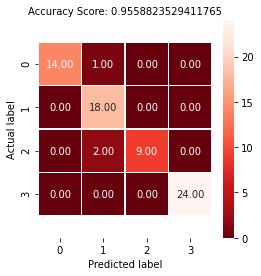

In [37]:
import seaborn as sns
score = accuracy_score(y_test, prediction)
plt.figure(figsize=(4,4))
ax = sns.heatmap(cmat, annot=True, fmt='.2f', linewidths=.5, square=True, cmap='Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {score}', size=10)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.show()

In [37]:
print(prediction == y_test)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


**Hyperparameter Tuning**

In [15]:
from sklearn.model_selection import GridSearchCV

def svc_param(X,y, nfolds):

  Cs = [0.001,0.01,0.1,1,10,15]
  gammas = [0.001,0.1,1]
  kernels = ['rbf', 'poly', 'sigmoid', 'linear']
  degrees = [2,3,4,5]
  param_grid = {'C':Cs, 'gamma':gammas, 'kernel': kernels, 'degree': degrees}
  grid_search = GridSearchCV(svm.SVC(),param_grid,cv=nfolds)
  grid_search.fit(X,y)
  grid_search.best_params_
  return grid_search.best_params_

In [16]:
svc_param(X_train_pca, y_train, 5) ##best params, degree are not used other than in poly kernel

{'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}

**Predicting with pictures from test set**

In [44]:
import random
a,b = random.randrange(0,68),random.randrange(0,68)
pair = [a,b] if a<b else [b,a]
print(pair)
img = X_test_pca[pair[0]:pair[1]]
lbl = y_test[pair[0]:pair[1]]
newpred = clf.predict(img)
cm = confusion_matrix(newpred, lbl)
sc = accuracy_score(newpred, lbl)
print(cm)
print(f'Accuracy score: {sc}')


[24, 39]
[[5 0 0 0]
 [0 3 0 0]
 [0 0 2 0]
 [0 0 0 5]]
Accuracy score: 1.0


Predict Single Image

In [51]:
import random
banks={
    1:'HLB',
    2:'HSBC',
    3:'MAYBANK',
    4:'RHB'
}
def cvt(x):
  return(banks[x])


for i in range(0,51):
  n = random.randrange(0,68)
  img = X_test_pca[n]
  lbl = y_test[n]
  newpred = clf.predict([img])
  if newpred[0] != lbl:
    print(f'Actual image: {cvt(lbl)}')
    print(f'Predicted image: {cvt(newpred[0])}\n')
    print(f'{n}')
    

TypeError: unhashable type: 'numpy.ndarray'

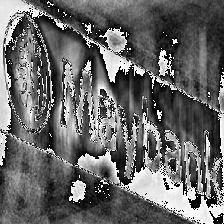

In [57]:
from PIL import Image
wrongimg = X_test[39].reshape(224,224)
wrongimg2 = X_test[50].reshape(224,224)
dis = Image.fromarray((wrongimg * 255).astype(np.uint8))
dis2 = Image.fromarray((wrongimg2 * 255).astype(np.uint8))
dis

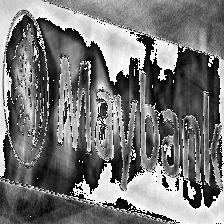

In [58]:
dis2